<a href="https://colab.research.google.com/github/saimathura/Books/blob/master/22233_VAE's_KMnist_MDSC_302.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saimathurakrishnan","key":"93f1782054d1d824aebb7eace9b87a9b"}'}

In [ ]:
! mkdir ~/.kaggle


In [ ]:


! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

400 - Bad Request - Unrecognized DatasetFileTypeGroup enum value


In [ ]:
!kaggle competitions download -c Kannada-MNIST

 81% 10.0M/12.4M [00:00<00:00, 16.6MB/s]
100% 12.4M/12.4M [00:01<00:00, 12.8MB/s]


# creating a custom DAtaset class

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
! mkdir train

In [ ]:
! unzip Kannada-MNIST.zip -d train

Archive:  Kannada-MNIST.zip
  inflating: train/Dig-MNIST.csv     
  inflating: train/sample_submission.csv  
  inflating: train/test.csv          
  inflating: train/train.csv         


In [ ]:
import pandas as pd

In [ ]:

# class Kmnist(Dataset):
#     def __init__(self, df, transform=None, target_transform=None):
#         self.img_labels = df.iloc[:,0]
#         # self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join( self.img_labels.iloc[idx, 0])
#         image = read_image(df.drop(df.columns[0],axis=1).iloc[idx,:].values)
#         label = self.img_labels.iloc[idx, 0]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

In [ ]:

class Kmnist(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.img_labels = df.iloc[:,0]
        # self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.df = df

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        #img_path = os.path.join( self.img_labels.iloc[idx, 0])
        image = (self.df.iloc[idx,1:].values)
        image = torch.tensor(image)
        #image = torch.reshape(image,(1,28,28))
        label = self.img_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
t_data = pd.read_csv('/content/train/train.csv')

In [ ]:
train_data = Kmnist(t_data)

In [ ]:
from torch.utils.data import random_split

In [ ]:
train_size = int(0.9 * (len(train_data)))

In [ ]:
val_size = len(train_data) - train_size

In [ ]:
train_set , val_set = random_split(train_data, [train_size, val_size])

In [ ]:
train_set.__len__()

54000

In [ ]:
val_set.__len__()


6000

In [ ]:
tt_data = pd.read_csv('/content/train/train.csv')

In [ ]:
test_data = Kmnist(tt_data)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(train_set,batch_size = 64,shuffle = True)
val_dataloader = DataLoader(val_set,batch_size = 64,shuffle = True)
test_dataloader = DataLoader(test_data,batch_size = 64,shuffle = True)

In [ ]:
train_features,train_labels = next(iter(train_dataloader))

In [ ]:
train_features.shape

torch.Size([64, 784])

Feature batch shape: torch.Size([64, 784])
Labels batch shape: torch.Size([64])


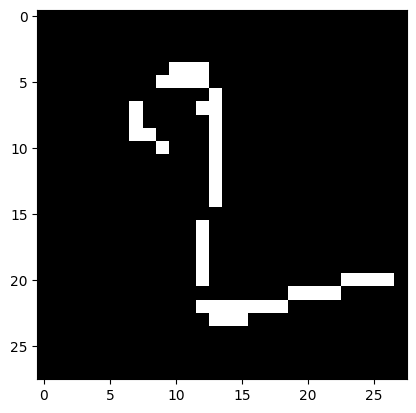

Label: 7


In [ ]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].reshape(28,28).squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
from torch import nn

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
import torch.nn.functional as F

In [ ]:
import torch
from torch.distributions.multivariate_normal \
 import MultivariateNormal
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.optim as optim

In [ ]:
class VAE(nn.Module):
 def __init__(self, D_in, H, D_out):
    super(VAE, self).__init__()
    self.D_in, self.H, self.D_out = D_in, H, D_out
    # Encoder layers (Gaussian MLP)
    self.input_layer = nn.Linear(D_in, H)
    self.hidden_layer_mean = nn.Linear(H, D_out)
    self.hidden_layer_var = nn.Linear(H, D_out)

    # Decoder layers (Bernoulli MLP for MNIST data)
    self.recon_layer = nn.Linear(D_out, H)
    self.recon_output = nn.Linear(H, D_in)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

 def encode(self, inp):
    h_vec = self.input_layer(inp)
    h_vec = self.sigmoid(h_vec)
    means = self.hidden_layer_mean(h_vec)
    log_vars = self.hidden_layer_var(h_vec)
    return means, log_vars
 def decode(self, means, log_vars):
    # Reparametrization trick
    std_devs = torch.pow(2,log_vars)**0.5
    aux = MultivariateNormal(torch.zeros(self.D_out),torch.eye(self.D_out)).sample()
    sample = means + aux * std_devs
    # Reconstruction
    h_vec = self.recon_layer(sample)
    h_vec = self.tanh(h_vec)
    output = self.sigmoid(self.recon_output(h_vec))
    return output

 def forward(self, inp):
        means, log_vars = self.encode(inp.float())
        output = self.decode(means, log_vars)
        return output, means, log_vars

 def reconstruct(self, sample):
        h_vec = self.recon_layer(sample)
        h_vec = self.tanh(h_vec)
        output = self.sigmoid(self.recon_output(h_vec))
        return output

In [ ]:
D_in, H, D_out = 784, 500, 20

In [ ]:
model = VAE(D_in, H, D_out)# loading THe Model

In [ ]:
#model.cuda()

In [ ]:
#print(model.device)

In [ ]:
device = torch.device("cpu")
model.to(device)

VAE(
  (input_layer): Linear(in_features=784, out_features=500, bias=True)
  (hidden_layer_mean): Linear(in_features=500, out_features=20, bias=True)
  (hidden_layer_var): Linear(in_features=500, out_features=20, bias=True)
  (recon_layer): Linear(in_features=20, out_features=500, bias=True)
  (recon_output): Linear(in_features=500, out_features=784, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
)

# using optimzer as Adam and the same  neural network from previous

In [ ]:
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
epochs = 10  # You can adjust the number of epochs as needed

In [ ]:
def compute_loss(inp, recon_inp, means, log_vars):
    # Calculate reverse KL divergence
    # (formula provided in Kingma and Welling)
    kl_loss = -0.5 * torch.sum(1 + log_vars- means ** 2 - torch.pow(2,log_vars))
    # Calculate BCE loss
    loss = nn.BCELoss(reduction="sum")
    recon_loss = loss(recon_inp, inp)
    return kl_loss + recon_loss

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []# for plotting

In [ ]:
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        #data = data.view((64,784))
        #print(data.shape)
        output, means, log_vars = model(data)
        loss = compute_loss(data.float(), output.float(), means.float(), log_vars.float())
        loss.backward()
        optimizer.step()
        if (batch_idx * len(data)) % 10000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}' \
                  .format(epoch, batch_idx * len(data), len(train_dataloader.dataset),100. * batch_idx / len(train_dataloader), loss.item()))
torch.save(vae.state_dict(), "vae.%d" % epoch)

Train Epoch: 0 [0/54000 (0%)]	Loss: -101954328.000000
Train Epoch: 0 [40000/54000 (74%)]	Loss: -99546184.000000
Train Epoch: 1 [0/54000 (0%)]	Loss: -103510296.000000
Train Epoch: 1 [40000/54000 (74%)]	Loss: -104118248.000000
Train Epoch: 2 [0/54000 (0%)]	Loss: -103994672.000000
Train Epoch: 2 [40000/54000 (74%)]	Loss: -94646648.000000
Train Epoch: 3 [0/54000 (0%)]	Loss: -101784448.000000
Train Epoch: 3 [40000/54000 (74%)]	Loss: -103330928.000000
Train Epoch: 4 [0/54000 (0%)]	Loss: -98905904.000000
Train Epoch: 4 [40000/54000 (74%)]	Loss: -105158168.000000
Train Epoch: 5 [0/54000 (0%)]	Loss: -111122008.000000
Train Epoch: 5 [40000/54000 (74%)]	Loss: -101830360.000000
Train Epoch: 6 [0/54000 (0%)]	Loss: -104067592.000000
Train Epoch: 6 [40000/54000 (74%)]	Loss: -103055976.000000
Train Epoch: 7 [0/54000 (0%)]	Loss: -106663248.000000
Train Epoch: 7 [40000/54000 (74%)]	Loss: -104905968.000000
Train Epoch: 8 [0/54000 (0%)]	Loss: -102528320.000000
Train Epoch: 8 [40000/54000 (74%)]	Loss: -103

In [ ]:
epoch

9

In [ ]:
#torch.save(vae.state_dict(), "vae.%d" % epoch)


In [ ]:
def test():
 dist = MultivariateNormal(torch.zeros(D_out), torch.eye(D_out))
 vae = VAE(D_in, H, D_out)
 vae.load_state_dict(torch.load("vae.%d" % 9))
 vae.eval()
 outputs = []

 for i in range(100):
    sample = dist.sample()
    outputs.append(vae.reconstruct(sample).view((1,1,28,28)))
 outputs = torch.stack(outputs).view(100,1,28,28)
 save_image(outputs, "prior_reconstruct_100.png", nrow=10)

In [ ]:
test()

In [ ]:
import torchvision
image = torchvision.io.read_image('/content/prior_reconstruct_100.png')

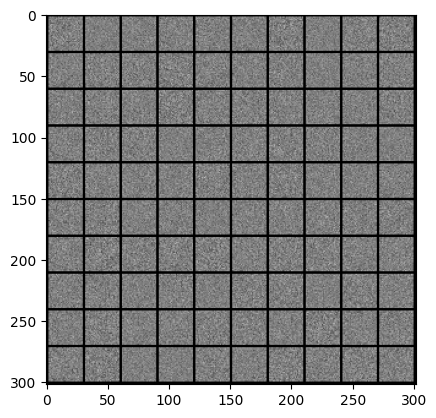

In [ ]:
plt.imshow(image.permute(1,2,0))

In [ ]:
D_in, H, D_out = 784, 500, 20
vae = VAE(D_in, H, D_out)
vae.to("cpu")
def train():
    vae.train()
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)
    train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',
        train=True,
        download = True,
        transform=transforms.ToTensor()),
        batch_size=100,
        shuffle=True)

    epochs = 10
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.view((100,784))
            output, means, log_vars = vae(data)
            loss = compute_loss(data, output, means, log_vars)
            loss.backward()
            optimizer.step()
            if (batch_idx * len(data)) % 10000 == 0:
                print(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}' \
                .format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [ ]:
train()

Train Epoch: 0 [0/60000 (0%)]	Loss: 54932.875000
Train Epoch: 0 [10000/60000 (17%)]	Loss: 23336.429688
Train Epoch: 0 [20000/60000 (33%)]	Loss: 19912.033203
Train Epoch: 0 [30000/60000 (50%)]	Loss: 18305.193359
Train Epoch: 0 [40000/60000 (67%)]	Loss: 18182.738281
Train Epoch: 0 [50000/60000 (83%)]	Loss: 16865.636719
Train Epoch: 1 [0/60000 (0%)]	Loss: 18919.531250
Train Epoch: 1 [10000/60000 (17%)]	Loss: 16920.599609
Train Epoch: 1 [20000/60000 (33%)]	Loss: 16746.642578
Train Epoch: 1 [30000/60000 (50%)]	Loss: 15743.332031
Train Epoch: 1 [40000/60000 (67%)]	Loss: 15450.982422
Train Epoch: 1 [50000/60000 (83%)]	Loss: 15515.539062
Train Epoch: 2 [0/60000 (0%)]	Loss: 14659.731445
Train Epoch: 2 [10000/60000 (17%)]	Loss: 14517.677734
Train Epoch: 2 [20000/60000 (33%)]	Loss: 15171.294922
Train Epoch: 2 [30000/60000 (50%)]	Loss: 14829.014648
Train Epoch: 2 [40000/60000 (67%)]	Loss: 14212.080078
Train Epoch: 2 [50000/60000 (83%)]	Loss: 14317.215820
Train Epoch: 3 [0/60000 (0%)]	Loss: 13562.1

In [ ]:
def test():
 dist = MultivariateNormal(torch.zeros(D_out), torch.eye(D_out))
 vae = VAE(D_in, H, D_out)
 vae.load_state_dict(torch.load("vae.%d" % 9))
 vae.eval()
 outputs = []

 for i in range(100):
    sample = dist.sample()
    outputs.append(vae.reconstruct(sample).view((1,1,28,28)))
 outputs = torch.stack(outputs).view(100,1,28,28)
 save_image(outputs, "prior_reconstruct_100-1.png", nrow=10)

In [ ]:
test()